In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable

from torchsummary import summary
from torch.utils.data import Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
import random

from torch.utils.data import DataLoader

from tqdm.auto import tqdm


In [3]:
import random
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(123123)

In [5]:
def get_binary_mask(anns):
    if len(anns) == 0:
        print('none')
        return None
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    mask_shape = sorted_anns[0]['segmentation'].shape
    
    binary_mask = np.zeros(mask_shape, dtype=np.uint8)
    
    for ann in sorted_anns:
        m = ann['segmentation']
        binary_mask[m] = 1
     
    return binary_mask

In [6]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        confidence = 1.0 - self.smoothing
        smoothed_target = torch.full_like(input, self.smoothing / (input.size(1) - 1))
        smoothed_target.scatter_(1, target.unsqueeze(1), confidence)
        log_prob = nn.functional.log_softmax(input, dim=1)
        loss = -(smoothed_target * log_prob).sum(dim=1)
        return loss.mean()

In [7]:
def convert_to_four_channel(image):
    # 确定图像的通道数
    num_channels = image.shape[2] if len(image.shape) == 3 else 1
    
    # 检查图像是否已经是四通道图像
    if num_channels == 4:
        return image
    
    # 创建一个具有四个通道的空白图像，初始时所有像素值都为完全不透明
    alpha_channel = np.ones((image.shape[0], image.shape[1], 1), dtype=np.uint8) * 255
    if num_channels == 1:
        # 如果是灰度图像或二值图像，将其复制到四通道图像的RGB通道中
        four_channel_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGBA)
#         print('Grey')
    elif num_channels == 3:
        # 如果是三通道图像，将其复制到四通道图像的RGB通道中
        four_channel_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
#         print('RGB')
    else:
        # 非法的图像类型，返回原始图像
#         print('GG')
        return image

    # 将Alpha通道添加到四通道图像中
#     four_channel_image = np.concatenate((four_channel_image, alpha_channel), axis=2)
    
    return four_channel_image

def convert_black_to_transparent(image):
    # 创建一个具有四个通道的空白图像，初始时所有像素值都为完全不透明
    transparent_image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    
    # 将原图中的黑色像素变为透明色
    black_pixels = np.all(transparent_image == [0, 0, 0, 255], axis=2)
    transparent_image[black_pixels] = [0, 0, 0, 0]
    
    return transparent_image

def expand_contour(image, contour, thickness):
    # 创建一个与输入图像相同大小的空白图像
    expanded_image = np.zeros_like(image)

    # 在空白图像上绘制轮廓，并设置扩展的线条厚度
    cv2.drawContours(expanded_image, [contour], 0, (0, 0, 0,255), thickness)

    # 将扩展后的区域与输入图像进行按位或操作，以实现扩展效果
    expanded_image = cv2.bitwise_or(image, expanded_image)

    return expanded_image

In [8]:
def masking(scr):
    
    # input: scribble
    # output: mask and correspondance
    
    scr_reshape = scr.reshape(-1, 3)
    color_set = np.unique([i for i in scr_reshape], axis = 0)
    corr = []
    
    for i,j in enumerate(color_set):
        scr_reshape[np.where(np.all(scr_reshape == j, axis = -1))[0]] = i
        corr.append(j)
    
    return scr_reshape[:,0], np.array(corr)

## 图像读取与增强

In [9]:
input_folder = '/kaggle/input/uhcsdataset/uhcs_dataset/Images'
background_folder = '/kaggle/input/uhcsdataset/uhcs_dataset/SAM/SAM_background'
label_folder = '/kaggle/input/uhcsdataset/uhcs_dataset/SAM/SAM_foreground'
ground_truth_image_folder = '/kaggle/input/uhcsdataset/uhcs_dataset/Labels'

In [11]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
dataset = []
for root, dirs, files in os.walk("/kaggle/input/uhcsdataset/uhcs_dataset/Images"):
    for file in files:
        if file.endswith((".jpg", ".png")):
            image_path = os.path.join(root, file)
            image = Image.open(image_path).convert("L") # 将图像转换为灰度模式
            tensor = transform(image)
            dataset.append(tensor.view(-1)) # 将每个图像展平为一维张量

dataset = torch.cat(dataset, dim=0) # 在第0维(行)上连接
mean = dataset.mean() # 计算整个数据集的均值
std = dataset.std() # 计算整个数据集的标准差

In [14]:
import albumentations as A
from tqdm.auto import tqdm

image_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.Rotate(limit=180, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.RandomScale(scale_limit=0.2, p=0.5),
        A.RandomCrop(height=256, width=256, p=1),

    ],
    additional_targets={'background': 'mask'}
)

In [15]:
test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
    ]
)

In [17]:
class MicroDataset(Dataset):
    def __init__(self, image_path, label_path, background_path, tfm=image_transform, files=None, thickness=0):
        self.image_path = image_path
        self.label_path = label_path
        self.background_path = background_path
        self.files = sorted([os.path.join(self.image_path, x) for x in os.listdir(self.image_path) if x.endswith(".jpg") or x.endswith(".png") or x.endswith(".jpeg")])
        if files is not None:
            self.files = files
        self.transform = tfm
        self.thickness = thickness

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = self.files[idx]
        label_path = os.path.join(self.label_path, os.path.basename(image_path))
        background_path = os.path.join(self.background_path, os.path.basename(image_path))

        # 加载图像和标签
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        background = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE)
        
        transformed_data = self.transform(image=image, mask=label,background = background)
        image_np = transformed_data['image']
        label_np = transformed_data['mask']
        background_np = transformed_data['background']

#         label_expand = cv2.dilate(label_np, np.ones((3, 3)), iterations=self.thickness)
        label_expand = label_np


        #启用扰动
#         # 获取膨胀和腐蚀之间的差值
#         label_tensor = torch.from_numpy(label_np.astype(np.uint8))
#         eroded_label = torch.from_numpy(cv2.erode(label_np, np.ones((3, 3), np.uint8), iterations=1))
#         dilated_label = torch.from_numpy(cv2.dilate(label_np, np.ones((3, 3), np.uint8), iterations=1))

#         changed_pixels_erode = (eroded_label != label_tensor).numpy()
#         changed_pixels_dilate = (dilated_label != label_tensor).numpy()

#         # 调整腐蚀像素
#         pixels_to_change_erode = torch.from_numpy(np.transpose(changed_pixels_erode.nonzero()))
#         num_erode_pixels = int(0.15 * pixels_to_change_erode.shape[0])
#         selected_erode_indices = torch.randperm(pixels_to_change_erode.shape[0])[:num_erode_pixels]
#         selected_erode_pixels = pixels_to_change_erode[selected_erode_indices]
#         label_tensor[selected_erode_pixels[:, 0], selected_erode_pixels[:, 1]] = 0

#         # 调整膨胀像素
#         pixels_to_change_dilate = torch.from_numpy(np.transpose(changed_pixels_dilate.nonzero()))
#         num_dilate_pixels = int(0.85 * pixels_to_change_dilate.shape[0])
#         selected_dilate_indices = torch.randperm(pixels_to_change_dilate.shape[0])[:num_dilate_pixels]
#         selected_dilate_pixels = pixels_to_change_dilate[selected_dilate_indices]
#         label_tensor[selected_dilate_pixels[:, 0], selected_dilate_pixels[:, 1]] = 0

#         # 将结果转换回NumPy格式
#         label_np = label_tensor.numpy()

#         # 将背景图片中像素值为0的像素加入到idx中
        background_mask = (background_np == 0).astype(np.uint8)
        background_pixels = np.transpose(background_mask.nonzero())
        
        #启用背景限制
#         num_selected = int(0.5 * background_pixels.shape[0])
#         selected_indices = np.random.choice(background_pixels.shape[0], size=num_selected, replace=False)
#         selected_rows = background_pixels[selected_indices, 0]
#         selected_cols = background_pixels[selected_indices, 1]
#         idx_background = torch.from_numpy(selected_rows * image_np.shape[1] + selected_cols)
        idx_background = torch.from_numpy(np.array([item[0] * image_np.shape[1] + item[1] for item in background_pixels]))


        # 合并修改像素的索引
        idx_roi = np.transpose(label_expand.nonzero())
        idx_roi = torch.from_numpy(np.array([item[0] * image_np.shape[1] + item[1] for item in idx_roi]))
        idx = torch.cat((idx_roi, idx_background), dim=0)
        
        # Remove duplicates
        idx_unique = torch.unique(idx)

        # Randomly sample 70% of the unique indices
#         num_unique = len(idx_unique)
#         num_to_sample = int(np.size(label_np) * 0.5)
#         idx_sampled = idx_unique[torch.randperm(num_unique)[:num_to_sample]]

        return image_np, label_np, idx_unique

In [18]:
same_seeds(3)
import time

# Set a global thickness for all samples
global_thickness = 3

# Start the timer
start_time = time.time()

# Create a MicroDataset object
micro_dataset = MicroDataset(image_path=input_folder, label_path=label_folder, background_path = background_folder, tfm=image_transform, thickness=global_thickness)

# Stop the timer
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Print the time taken
print("Time taken to create MicroDataset object:", time_taken)

# Start the timer
start_time = time.time()

# Choose an index to retrieve a sample from the dataset
sample_index = 0

# Retrieve a sample from the dataset
image, label, idx = micro_dataset[sample_index]

# Stop the timer
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Print the time taken
print("Time taken to retrieve a sample from the dataset:", time_taken)

Time taken to create MicroDataset object: 0.0008020401000976562
Time taken to retrieve a sample from the dataset: 0.12598443031311035


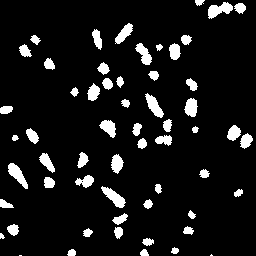

In [20]:
im = Image.fromarray(label)
im

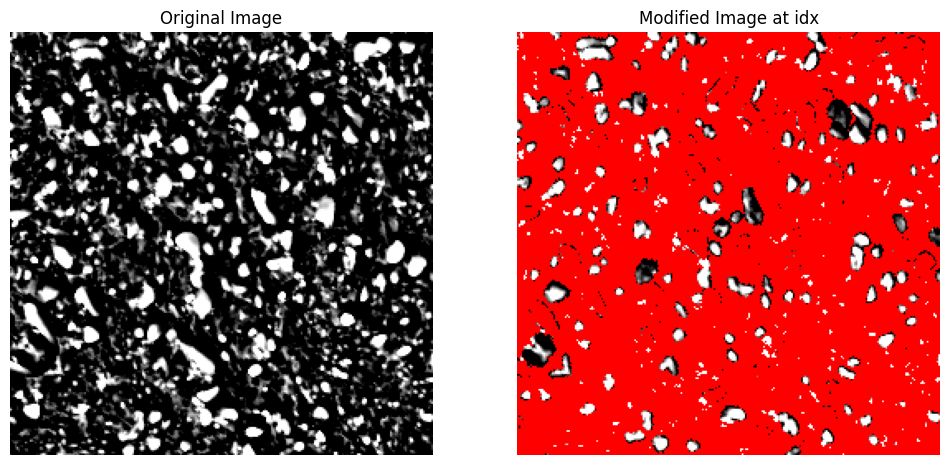

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np


rgb_image = np.tile(image[..., np.newaxis], (1, 1, 3))

idx_roi_grey = idx

# Assuming you have already loaded the images using the code you provided
# image, label, expanded_label, idx_roi_grey = micro_dataset[sample_index]


# Create a copy of the original image
modified_image = rgb_image.copy()

# Convert flattened indices back to 2D indices using numpy
idx_roi_grey_2d = np.unravel_index(idx_roi_grey.cpu().numpy(), label.shape[:2])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(modified_image)
plt.axis('off')

# Set the pixels specified by idx_roi_grey_2d to red (you can modify this based on your requirement)
modified_image[idx_roi_grey_2d[0], idx_roi_grey_2d[1]] = [255, 0, 0]  # Set to red

# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 2)
plt.title('Modified Image at idx')
plt.imshow(modified_image)
plt.axis('off')

# Show the plot
plt.show()


## Model

In [22]:
## U-net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            # 三个通道  1  100 10000 --> 1 1.2  1.3
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=4, out_channels=2, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [24]:
class Model(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(Model, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        if num_layers == 0:
            self.conv4 = nn.Conv2d(input_dim, k, 1)
            self.bn4 = nn.BatchNorm2d(k)
            
        else:           
            # 添加第一层卷积层和批归一化层
            self.conv_layers.append(nn.Conv2d(input_dim, 64, 3, padding=1))
            self.bn_layers.append(nn.BatchNorm2d(64))

            # 添加额外的卷积层和批归一化层
            for _ in range(num_layers - 1):
                self.conv_layers.append(nn.Conv2d(64, 64, 3, padding=1))
                self.bn_layers.append(nn.BatchNorm2d(64))

            self.conv4 = nn.Conv2d(64, k, 1)
            self.bn4 = nn.BatchNorm2d(k)

    def forward(self, x):
        for conv, bn in zip(self.conv_layers, self.bn_layers):
            x = F.relu(bn(conv(x)))

        x = self.bn4(self.conv4(x))
        return x

In [25]:
def masking(binary_image):
    # input: binary_image (assuming it's a 2D array)
    # output: mask and correspondance

    binary_reshape = binary_image.reshape(-1)
    unique_values = np.unique(binary_reshape)
    corr = []

    for i, value in enumerate(unique_values):
        binary_reshape[binary_reshape == value] = i
        corr.append(value)

    return binary_reshape, np.array(corr)

In [26]:
n_epochs = 2000
batch_size = 8
k = 2
lr = 0.01
weight_decay = 1e-5

In [27]:
model = UNET(in_channels=3, out_channels=2)  
#CNN
# model = Model(3,num_layers = 3)    


model = model.cuda()

In [28]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

## DATALOADER

In [29]:
from torch.utils.data.dataloader import default_collate

def custom_collate(batch):
    # 覆盖默认的 collate 函数，将 batch 元素原样返回
    return batch

# 使用自定义 collate 函数创建 DataLoader
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate)


In [30]:
train_set = MicroDataset(image_path=input_folder, label_path=label_folder, background_path = background_folder, tfm=image_transform, thickness=global_thickness)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate)

In [31]:
from sklearn.utils.class_weight import compute_class_weight

In [32]:
from tqdm import tqdm

same_seeds(123)

min_loss = float('inf')
best_epoch = -1

save_interval = 10  # Adjust the save interval as needed

train_losses = []


for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        loss = torch.tensor(0.0, device='cuda')  # 初始化为0的张量
        
        for imgs, labels, idx_roi in batch:
            idx_roi = torch.as_tensor(idx_roi, dtype=torch.long)

            img_ = np.tile(imgs[..., np.newaxis], (1, 1, 3))
            img_ = torch.from_numpy((img_.transpose((2, 0, 1)).astype('float32') / 255.)[np.newaxis, :, :, :])
            img_ = img_.cuda()

            pred = model(img_)[0]
            pred = pred.squeeze()
            pred = pred.permute(1, 2, 0)
            pred = pred.contiguous().view(-1, k)

            dict_label, corr = masking(labels)
            mask = torch.from_numpy(dict_label).long()

    #         #权重规划，注意数据类型
#             class_weights = compute_class_weight('balanced', classes=list(np.unique(mask)), y=mask[idx_roi].numpy())
#             class_weights = torch.from_numpy(class_weights)
#             class_weights = class_weights.float()
#             class_weights = class_weights.cuda()


            idx_roi= idx_roi.cuda()
            mask = mask.long()
            mask = mask.cuda()
            pred = pred.cuda()


#             criterion = nn.CrossEntropyLoss(weight=class_weights)
#             criterion = SmoothCrossEntropyLoss(smoothing=0.1)
            criterion = nn.CrossEntropyLoss()

            loss_img = criterion(pred[idx_roi], mask[idx_roi])
            loss += loss_img
            
            

        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        total_loss += loss.item()
        
        # 释放不必要的变量和清除CUDA缓存
        del loss_img, loss, pred, mask, idx_roi, img_
        torch.cuda.empty_cache()


    # Calculate average loss for the epoch
    avg_loss = total_loss / (len(train_loader)*batch_size)

    train_losses.append(avg_loss)

    # Print loss every 50 epochs
    if (epoch + 1) % 100 == 0:
        tqdm.write(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss}')

    # Check if the current model has the minimum loss
    if avg_loss < min_loss:
        min_loss = avg_loss
        best_epoch = epoch
        # Save the model with the current minimum loss
        model_filename = f'/kaggle/working/best_model.pt'
        torch.save(model.state_dict(), model_filename)
        if (epoch + 1) % save_interval == 0:
            tqdm.write(f'Best model saved at: {model_filename} with loss: {min_loss:.4f}')

print(f'Training complete. Best model found at epoch {best_epoch + 1} with loss: {min_loss:.4f}')


Training Progress:   0%|          | 10/2000 [00:40<1:56:39,  3.52s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.1751


Training Progress:   1%|          | 20/2000 [01:14<1:52:33,  3.41s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.1187


Training Progress:   2%|▏         | 30/2000 [01:48<1:51:21,  3.39s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0879


Training Progress:   2%|▏         | 40/2000 [02:21<1:50:01,  3.37s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0717


Training Progress:   2%|▎         | 50/2000 [02:53<1:46:17,  3.27s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0623


Training Progress:   4%|▍         | 80/2000 [04:31<1:46:39,  3.33s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0486


Training Progress:   5%|▌         | 100/2000 [05:36<1:43:50,  3.28s/it]

Epoch [100/2000], Loss: 0.047391943633556366


Training Progress:   6%|▌         | 110/2000 [06:09<1:44:46,  3.33s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0431


Training Progress:   6%|▌         | 120/2000 [06:42<1:43:33,  3.30s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0424


Training Progress:  10%|█         | 200/2000 [11:03<1:35:47,  3.19s/it]

Epoch [200/2000], Loss: 0.041442385564247765


Training Progress:  15%|█▌        | 300/2000 [16:26<1:31:45,  3.24s/it]

Epoch [300/2000], Loss: 0.03352088232835134


Training Progress:  20%|██        | 400/2000 [21:48<1:25:19,  3.20s/it]

Epoch [400/2000], Loss: 0.029462778319915135


Training Progress:  22%|██▎       | 450/2000 [24:30<1:26:08,  3.33s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0275


Training Progress:  25%|██▌       | 500/2000 [27:11<1:20:59,  3.24s/it]

Epoch [500/2000], Loss: 0.02930804155766964


Training Progress:  30%|███       | 600/2000 [32:33<1:15:13,  3.22s/it]

Epoch [600/2000], Loss: 0.030324901764591534


Training Progress:  35%|███▌      | 700/2000 [37:55<1:09:32,  3.21s/it]

Epoch [700/2000], Loss: 0.02615499496459961


Training Progress:  40%|████      | 800/2000 [43:18<1:04:34,  3.23s/it]

Epoch [800/2000], Loss: 0.025385441879431408


Training Progress:  45%|████▌     | 900/2000 [48:42<58:59,  3.22s/it]  

Epoch [900/2000], Loss: 0.025911662106712658


Training Progress:  50%|█████     | 1000/2000 [54:05<54:08,  3.25s/it]

Epoch [1000/2000], Loss: 0.023809862012664478


Training Progress:  55%|█████▌    | 1100/2000 [59:27<48:21,  3.22s/it]

Epoch [1100/2000], Loss: 0.02421393059194088


Training Progress:  60%|██████    | 1200/2000 [1:04:49<43:17,  3.25s/it]

Epoch [1200/2000], Loss: 0.02425498701632023


Training Progress:  62%|██████▏   | 1230/2000 [1:06:25<41:50,  3.26s/it]

Best model saved at: /kaggle/working/best_model.pt with loss: 0.0212


Training Progress:  65%|██████▌   | 1300/2000 [1:10:11<38:54,  3.34s/it]

Epoch [1300/2000], Loss: 0.024793297052383423


Training Progress:  70%|███████   | 1400/2000 [1:15:35<31:42,  3.17s/it]

Epoch [1400/2000], Loss: 0.023236163581411045


Training Progress:  75%|███████▌  | 1500/2000 [1:20:56<26:16,  3.15s/it]

Epoch [1500/2000], Loss: 0.022660040607055027


Training Progress:  80%|████████  | 1600/2000 [1:26:15<21:14,  3.19s/it]

Epoch [1600/2000], Loss: 0.021793800095717113


Training Progress:  85%|████████▌ | 1700/2000 [1:31:33<15:54,  3.18s/it]

Epoch [1700/2000], Loss: 0.023559545477231342


Training Progress:  90%|█████████ | 1800/2000 [1:36:51<10:34,  3.17s/it]

Epoch [1800/2000], Loss: 0.022971581667661667


Training Progress:  95%|█████████▌| 1900/2000 [1:42:09<05:16,  3.16s/it]

Epoch [1900/2000], Loss: 0.02058292118211587


Training Progress: 100%|██████████| 2000/2000 [1:47:27<00:00,  3.22s/it]

Epoch [2000/2000], Loss: 0.02375289611518383
Training complete. Best model found at epoch 1933 with loss: 0.0194


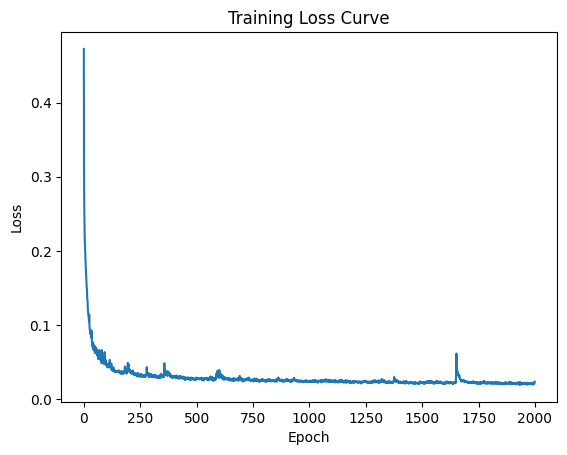

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Save the loss curve to a CSV file
loss_df = pd.DataFrame({'Epoch': n_epochs  * batch_size, 'Loss': train_losses})
loss_df.to_csv('loss_curve.csv', index=False)

In [34]:
def convert_to_three_channel(image_path):
    # Read the image
    image = Image.open(image_path)
    
    image = np.array(image)
    
    # Check if the image is a binary image
    unique_values = np.unique(image)
    is_binary =  (len(image.shape) == 2)

    if is_binary:
        # If it's a binary image, convert it to a 3-channel image
        three_channel_image = np.repeat(np.array(image)[:, :, np.newaxis], 3, axis=2)
        return three_channel_image 
    else:
        # If it's not a binary image, return the original image
        return image
    
def compute_iou_precision_recall(predicted_image_path, ground_truth_image_path):
    # Read the predicted image and ground truth image
    predicted_image = np.array(convert_to_three_channel(predicted_image_path))
    ground_truth_image = np.array(convert_to_three_channel(ground_truth_image_path))
   
    # Ensure that the predicted image and ground truth image have the same size
    if predicted_image.shape != ground_truth_image.shape:
        print(predicted_image.shape)
        print(ground_truth_image.shape)
        raise ValueError("The size of the predicted image and ground truth image does not match")

    # Convert the predicted image and ground truth image to boolean arrays
    predicted_binary = (predicted_image > 0)
    ground_truth_binary = (ground_truth_image > 0)

    # Compute the intersection
    intersection = np.logical_and(predicted_binary, ground_truth_binary)

    # Compute the union
    union = np.logical_or(predicted_binary, ground_truth_binary)

    # Compute the IoU value
    iou = np.sum(intersection) / np.sum(union)

    # Compute Precision and Recall
    true_positive = np.sum(np.logical_and(predicted_binary, ground_truth_binary))
    false_positive = np.sum(np.logical_and(predicted_binary, np.logical_not(ground_truth_binary)))
    false_negative = np.sum(np.logical_and(np.logical_not(predicted_binary), ground_truth_binary))
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return iou, precision, recall

In [35]:
import shutil
import os

# 指定要删除的文件夹路径
folder_path = "/kaggle/working/predict"

try:
    # 删除文件夹及其内容
    shutil.rmtree(folder_path)
    print(f"文件夹 '{folder_path}' 已成功删除。")
except FileNotFoundError:
    print(f"文件夹 '{folder_path}' 不存在。")
except PermissionError:
    print(f"无权限删除文件夹 '{folder_path}'。")
except Exception as e:
    print(f"删除文件夹 '{folder_path}' 时发生错误: {str(e)}")

文件夹 '/kaggle/working/predict' 不存在。


In [36]:
import numpy as np
import os
import cv2
import torch
import torch.nn.functional as F

# Set the path to the model file
model_path = model_filename

# Set input and output folder paths
deal_folder = input_folder
output_folder = '/kaggle/working/predict'
heatmap_folder = '/kaggle/working/heatmap'  # New folder for heatmap images

# Create output folders if they don't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(heatmap_folder, exist_ok=True)

# Load the model
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get a list of all image files in the input folder
image_files = os.listdir(deal_folder)

# Iterate over the image files
for file in image_files:
    # Build the image file path
    image_path = os.path.join(deal_folder, file)
    
#     # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 使用 albumentations 进行归一化
    img_norm = test_transform(image=img)['image']
    
    img_ = np.tile(img_norm[..., np.newaxis], (1, 1, 3))
    img_ = torch.from_numpy((img_.transpose((2, 0, 1)).astype('float32') / 255.)[np.newaxis, :, :, :])
    img_ = img_.cuda()
    

    # no norm
#     img = cv2.imread(image_path)
    
#     img_ = torch.from_numpy((img.transpose((2, 0, 1)).astype('float32') / 255.)[np.newaxis, :, :, :])
#     img_ = img_.to(device)
    
    # Image preprocessing and model inference
    model.eval()
    pred = model(img_)[0]
    pred = pred.permute(1, 2, 0)
    prob_map = F.softmax(pred, dim=2)
    _, pred_max = torch.max(pred, 2)
    pred_max = pred_max.cpu().numpy()
    pred_max_gray = (pred_max * 255).astype('uint8')
    
    # Calculate heatmap
    heatmap = prob_map[:, :, 1]  # Assuming class 1 is of interest
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = (heatmap * 255).astype('uint8')
    
    # Build the save file names
    save_name = file.split('.')[0] + '.png'
    heatmap_name = file.split('.')[0] + '_heatmap.png'
    
    # Build the save file paths
    save_path = os.path.join(output_folder, save_name)
    heatmap_path = os.path.join(heatmap_folder, heatmap_name)
    
    # Save the predicted result image
    cv2.imwrite(save_path, pred_max_gray)
    
    # Save the heatmap image
    cv2.imwrite(heatmap_path, heatmap)
    
    print(f"Image {file} predicted and saved successfully!")

Image 970C-5M-Q-5.png predicted and saved successfully!
Image 800C-24H-Q-7.png predicted and saved successfully!
Image 800C-85H-Q-1.png predicted and saved successfully!
Image 800C-24H-Q-5.png predicted and saved successfully!
Image 800C-85H-Q-6.png predicted and saved successfully!
Image 800C-8H-Q-3.png predicted and saved successfully!
Image 800C-85H-Q-2.png predicted and saved successfully!
Image 800C-85H-Q-3.png predicted and saved successfully!
Image 800C-24H-Q-4.png predicted and saved successfully!
Image 970C-5M-Q-3.png predicted and saved successfully!
Image 800C-24H-Q-1.png predicted and saved successfully!
Image 970C-5M-Q-1.png predicted and saved successfully!
Image 800C-85H-Q-5.png predicted and saved successfully!
Image 800C-3H-Q-3.png predicted and saved successfully!
Image 800C-3H-Q-2.png predicted and saved successfully!
Image 800C-8H-Q-1.png predicted and saved successfully!
Image 800C-24H-Q-2.png predicted and saved successfully!
Image 800C-24H-Q-3.png predicted and s

In [38]:
import numpy as np
from skimage import io, color
import os

def convert_to_binary(image_path, threshold=0.5):
    # Read the image as a single-channel grayscale image
    image = io.imread(image_path, as_gray=True)
    # Apply a threshold to convert it to a binary image
    binary_image = (image > threshold).astype(np.uint8)
    return binary_image

def compute_iou_precision_recall(predicted_image_path, ground_truth_image_path, threshold=0.5):
    # Read the predicted image and ground truth image
    predicted_image = convert_to_binary(predicted_image_path, threshold)
    ground_truth_image = convert_to_binary(ground_truth_image_path, threshold)
   
    # Ensure that the predicted image and ground truth image have the same size
    if predicted_image.shape != ground_truth_image.shape:
        print(predicted_image.shape)
        print(ground_truth_image.shape)
        raise ValueError("The size of the predicted image and ground truth image does not match")

    # Compute the intersection
    intersection = np.logical_and(predicted_image, ground_truth_image)

    # Compute the union
    union = np.logical_or(predicted_image, ground_truth_image)

    # Compute the IoU value, handling the case where both the numerator and denominator are zero
    iou = np.sum(intersection) / np.maximum(np.sum(union), 1)

    # Compute Precision and Recall
    true_positive = np.sum(np.logical_and(predicted_image, ground_truth_image))
    false_positive = np.sum(np.logical_and(predicted_image, np.logical_not(ground_truth_image)))
    false_negative = np.sum(np.logical_and(np.logical_not(predicted_image), ground_truth_image))
    
    precision = true_positive / np.maximum((true_positive + false_positive), 1e-8)
    recall = true_positive / np.maximum((true_positive + false_negative), 1e-8)

    return iou, precision, recall


In [39]:
predicted_image_folder = '/kaggle/working/predict'
# ground_truth_image_folder = '/kaggle/input/uhcs-dataset/uhcs_dataset/Labels'

contents = os.listdir(predicted_image_folder)
iou_sum = 0
precision_sum = 0
recall_sum = 0
count = 0

for item in contents:
    predict_image_path = os.path.join(predicted_image_folder, item)
    
    ground_truth_label = os.path.join(ground_truth_image_folder, item.split('.')[0] + '.png')
    
    iou, precision, recall = compute_iou_precision_recall(predict_image_path, ground_truth_label)
    
    iou_sum += iou
    precision_sum += precision
    recall_sum += recall
    count += 1
    
    print(f"IoU for {item}: {iou}")
    print(f"Precision for {item}: {precision}")
    print(f"Recall for {item}: {recall}")

average_iou = iou_sum / count
average_precision = precision_sum / count
average_recall = recall_sum / count

print(f"Average IoU: {average_iou}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")

IoU for 970C-5M-Q-4.png: 0.6137146115216772
Precision for 970C-5M-Q-4.png: 0.75083840849945
Recall for 970C-5M-Q-4.png: 0.7706669604009473
IoU for 800C-24H-Q-7.png: 0.5543927534957348
Precision for 800C-24H-Q-7.png: 0.7887147727628163
Recall for 800C-24H-Q-7.png: 0.6510883317410726
IoU for 800C-24H-Q-2.png: 0.6073783477932856
Precision for 800C-24H-Q-2.png: 0.7392294413633526
Recall for 800C-24H-Q-2.png: 0.7730004800768123
IoU for 800C-24H-Q-5.png: 0.637774762550882
Precision for 800C-24H-Q-5.png: 0.7800975868821987
Recall for 800C-24H-Q-5.png: 0.7775682382133995
IoU for 800C-3H-Q-1.png: 0.21037104277771473
Precision for 800C-3H-Q-1.png: 0.5771206225680934
Recall for 800C-3H-Q-1.png: 0.24870883359044874
IoU for 970C-5M-Q-2.png: 0.6415197773467151
Precision for 970C-5M-Q-2.png: 0.766629711751663
Recall for 970C-5M-Q-2.png: 0.7972016978462506
IoU for 800C-85H-Q-5.png: 0.7489730791260945
Precision for 800C-85H-Q-5.png: 0.7848739495798319
Recall for 800C-85H-Q-5.png: 0.9424435246391137
IoU

In [40]:
import os
import cv2
import numpy as np


predicted_image_folder = '/kaggle/working/predict'
# ground_truth_image_folder = '/kaggle/input/oneimage/nickel-based_oneimage/label'

contents = os.listdir(ground_truth_image_folder)
iou_sum = 0
count = 0

for item in contents:
    item_path = os.path.join(ground_truth_image_folder, item)
    
    predict_label = os.path.join(predicted_image_folder, item_path.split('/')[-1].split('.')[0] + '.png')
    
    # Load the original images
    original_image = cv2.imread(item_path, cv2.IMREAD_UNCHANGED)
    predicted_image = cv2.imread(predict_label, cv2.IMREAD_UNCHANGED)

    max_iou = 0  # Variable to store the maximum IoU
    best_shift = (0, 0)  # Variable to store the best shift

    # Iterate through all eight directions (up, down, left, right, and diagonals)
    for i in range(-1, 2):
        for j in range(-1, 2):
            # Shift the image
            shifted_image = np.roll(predicted_image, (i, j), axis=(0, 1))


            # Save the shifted image temporarily
            shifted_image_path = '/kaggle/working/shifted_image.png'
            cv2.imwrite(shifted_image_path, shifted_image)

            # Calculate IoU for the shifted image
            iou, _, _ = compute_iou_precision_recall(shifted_image_path, item_path)
            
            if i == -1 and j == 0:
                print(iou)

            # Update the maximum IoU and best shift if the current IoU is higher
            if iou > max_iou:
                max_iou = iou
                best_shift = (i, j)

    iou_sum += max_iou
    count += 1

    print(f"Max IoU for {item}: {max_iou} with shift {best_shift}")

average_iou = iou_sum / count
print(f"Average Max IoU: {average_iou}")



0.674394556007739
Max IoU for 970C-5M-Q-5.png: 0.674394556007739 with shift (-1, 0)
0.5254822422647046
Max IoU for 800C-24H-Q-7.png: 0.5543927534957348 with shift (0, 0)
0.7755907346704158
Max IoU for 800C-85H-Q-1.png: 0.7925501882057716 with shift (0, 0)
0.6846571480411451
Max IoU for 800C-24H-Q-5.png: 0.6846571480411451 with shift (-1, 0)
0.6673091562869499
Max IoU for 800C-85H-Q-6.png: 0.708145960207756 with shift (0, 0)
0.6806180086388305
Max IoU for 800C-8H-Q-3.png: 0.6937682081505542 with shift (0, 0)
0.6730084532884821
Max IoU for 800C-85H-Q-2.png: 0.6880523659445045 with shift (0, 0)
0.7650013954786492
Max IoU for 800C-85H-Q-3.png: 0.7650013954786492 with shift (-1, 0)
0.4316918810146907
Max IoU for 800C-24H-Q-4.png: 0.4316918810146907 with shift (-1, 0)
0.6316845282200495
Max IoU for 970C-5M-Q-3.png: 0.6316845282200495 with shift (-1, 0)
0.5254822422647046
Max IoU for 800C-24H-Q-1.png: 0.5543927534957348 with shift (0, 0)
0.6323937595712098
Max IoU for 970C-5M-Q-1.png: 0.63239

In [41]:
import zipfile
import os

# 定义要压缩的文件夹路径和压缩包路径
folder_path = '/kaggle/working/predict'
zip_path = '/kaggle/working/predict.zip'

# 创建一个ZipFile对象，并以写模式打开压缩包文件
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # 遍历文件夹中的文件和子文件夹
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # 构建文件的完整路径
            file_path = os.path.join(root, file)
            # 将文件添加到压缩包中，第一个参数是文件的完整路径，第二个参数是在压缩包中的相对路径（可根据需求设置）
            zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

print("压缩包已创建：", zip_path)

压缩包已创建： /kaggle/working/predict.zip


In [42]:
import zipfile
import os

# 定义要压缩的文件夹路径和压缩包路径
folder_path = '/kaggle/working/heatmap'
zip_path = '/kaggle/working/heatmaps.zip'

# 创建一个ZipFile对象，并以写模式打开压缩包文件
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # 遍历文件夹中的文件和子文件夹
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # 构建文件的完整路径
            file_path = os.path.join(root, file)
            # 将文件添加到压缩包中，第一个参数是文件的完整路径，第二个参数是在压缩包中的相对路径（可根据需求设置）
            zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

print("压缩包已创建：", zip_path)

压缩包已创建： /kaggle/working/heatmaps.zip


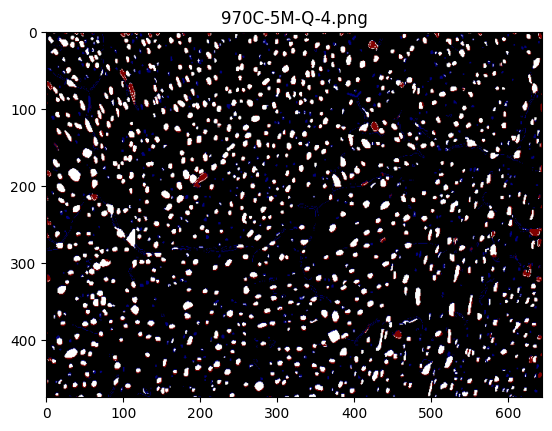

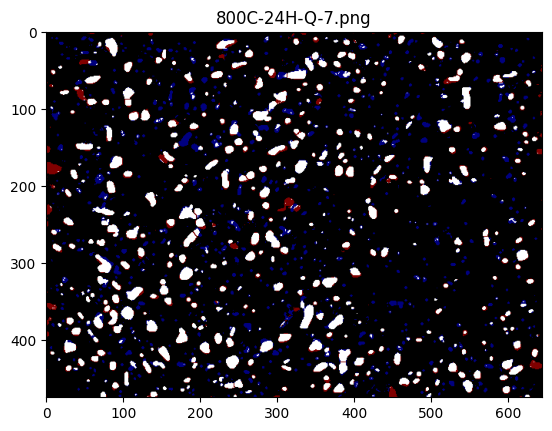

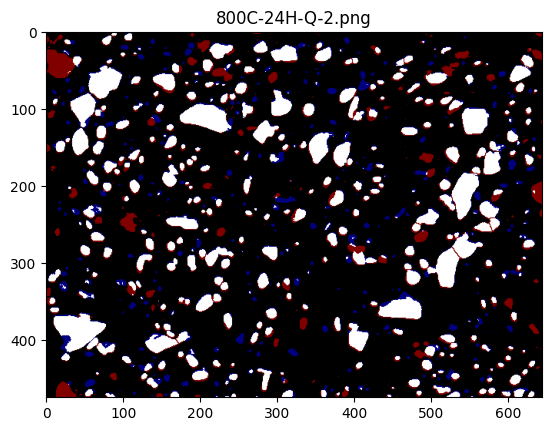

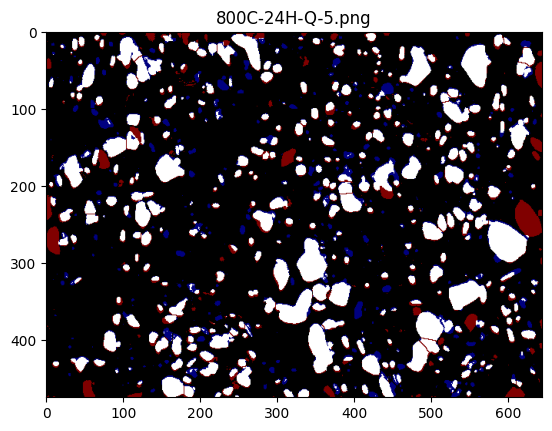

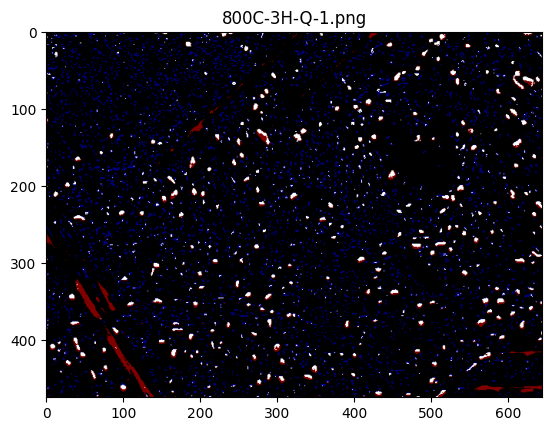

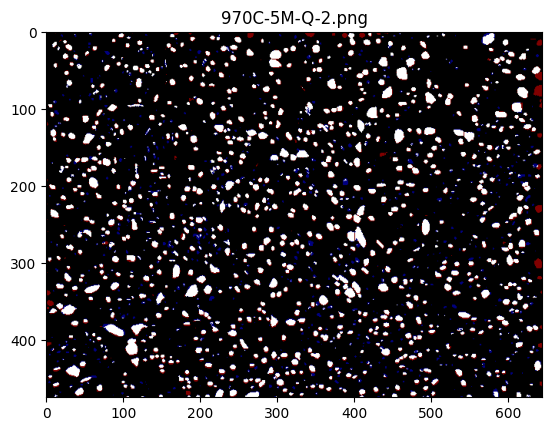

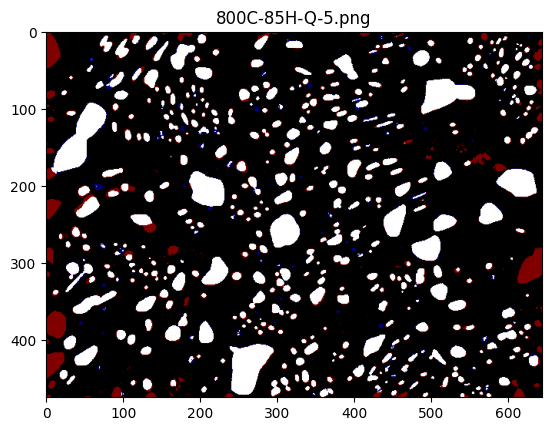

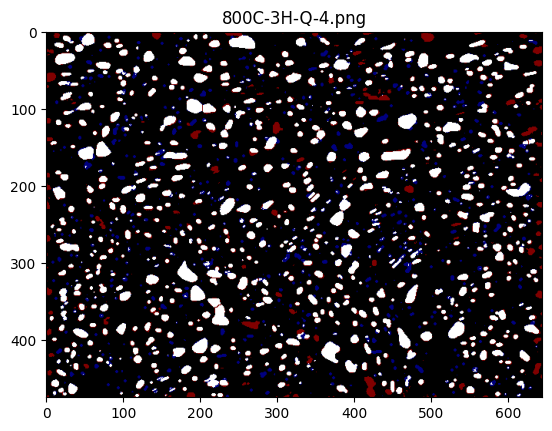

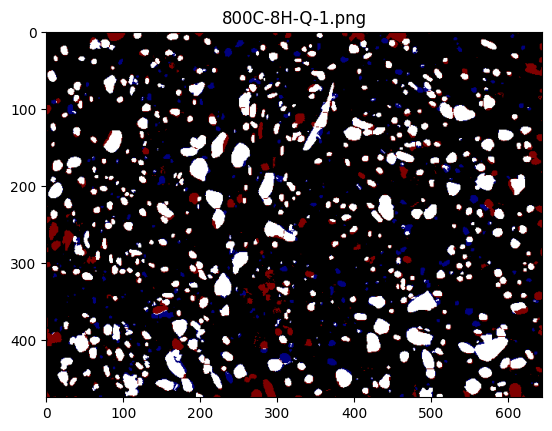

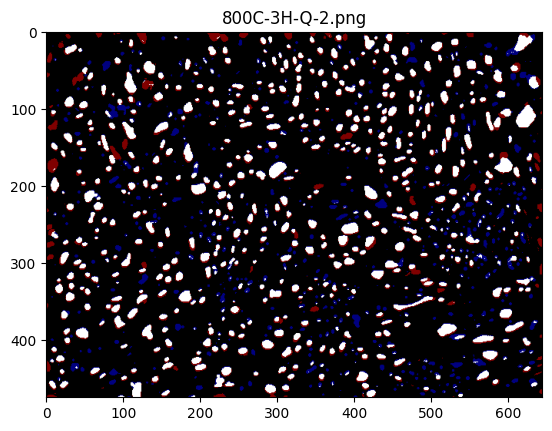

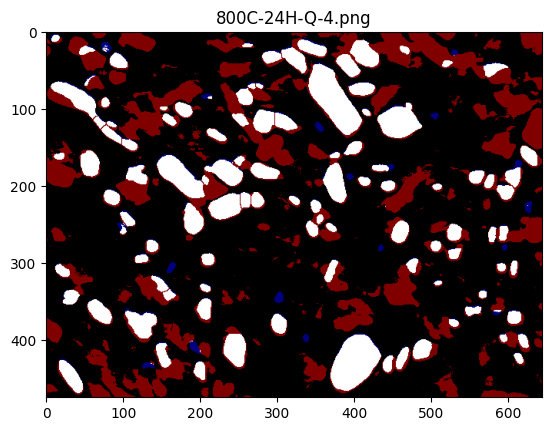

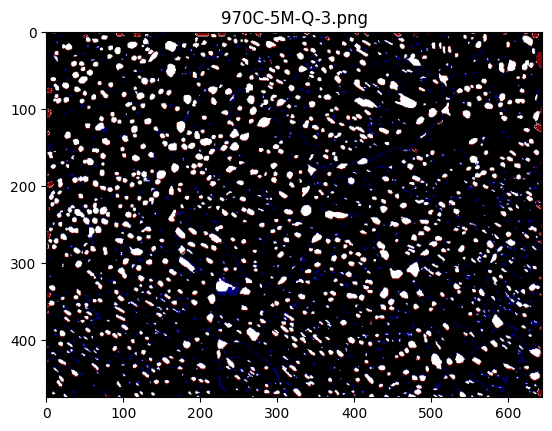

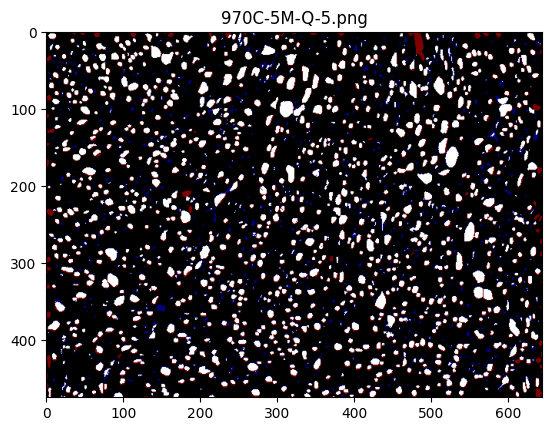

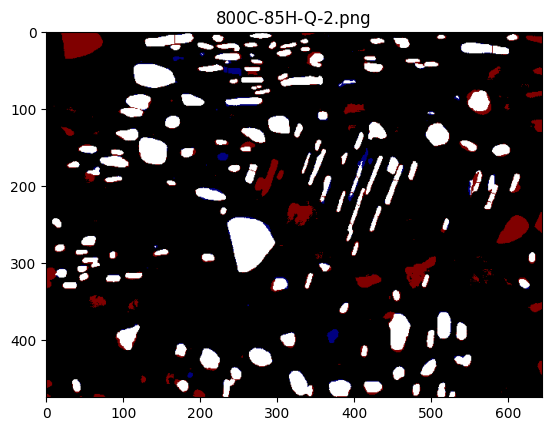

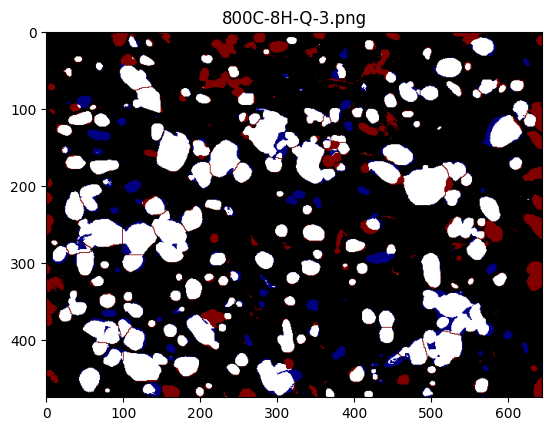

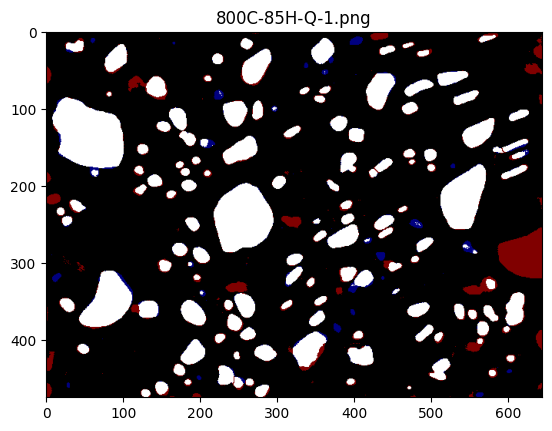

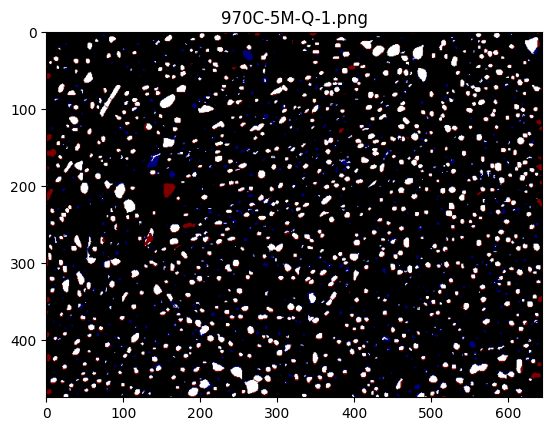

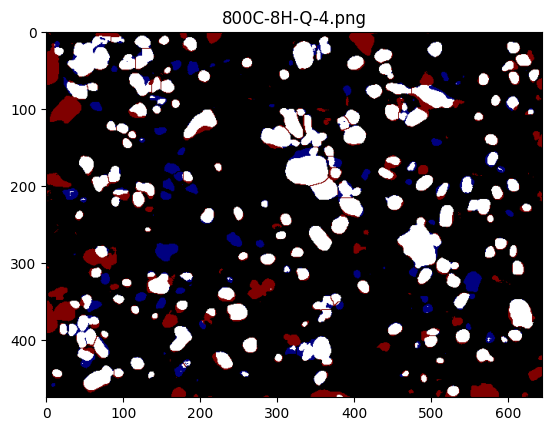

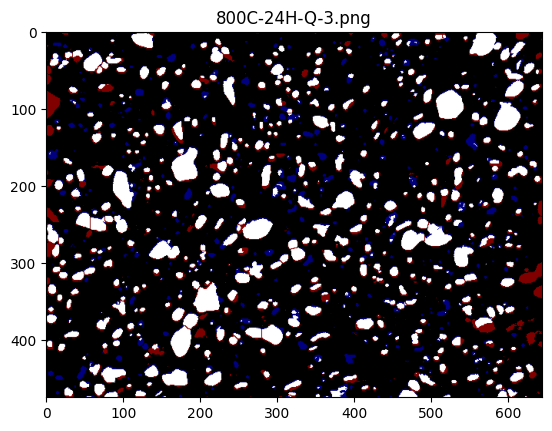

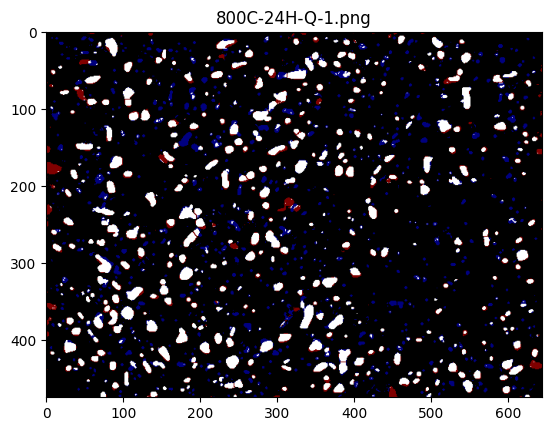

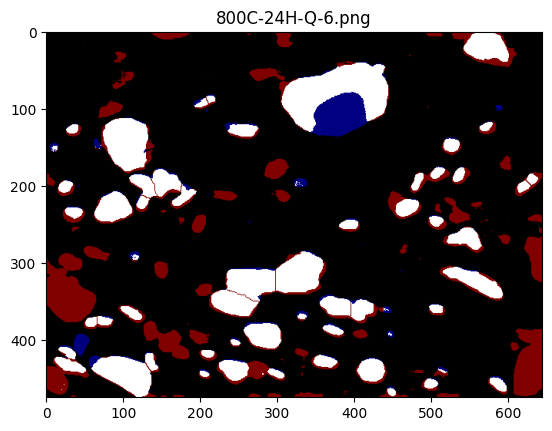

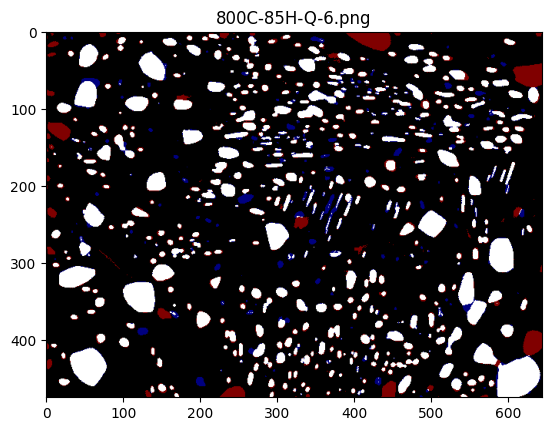

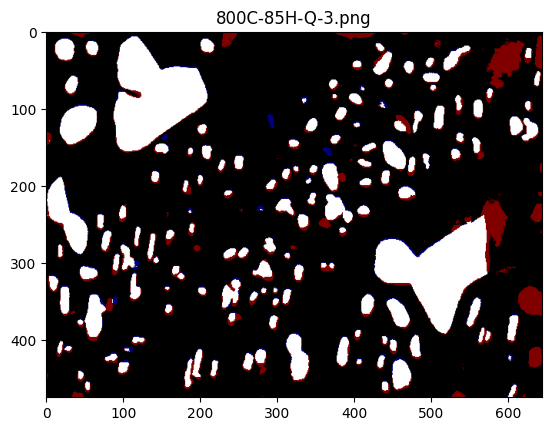

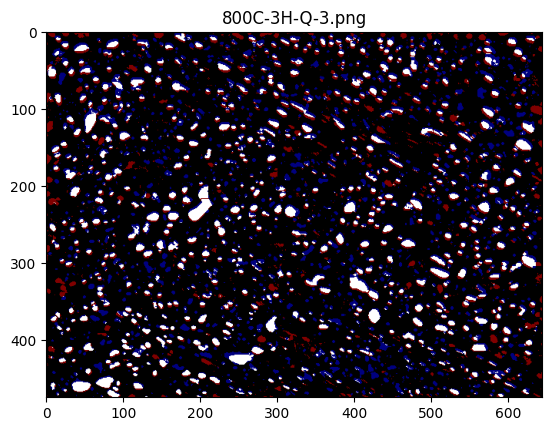

In [43]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

predicted_image_folder = '/kaggle/working/predict'

contents = os.listdir(predicted_image_folder)

for item in contents:
    item_path = os.path.join(ground_truth_image_folder, item)
    
    predict_label = os.path.join(predicted_image_folder, item_path.split('/')[-1].split('.')[0] + '.png')
    
    predict_image = cv2.imread(predict_label)
    ground_truth_image = cv2.imread(item_path)
    
    # Compute the difference between the two images
    difference = cv2.absdiff(predict_image, ground_truth_image)
    
    # Convert the difference to grayscale
    difference_gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    
    # Threshold the difference image to highlight the differences
    thresh = cv2.threshold(difference_gray, 127, 255, cv2.THRESH_BINARY)[1]
    
    # Create masks for areas where prediction is more than ground truth (in red) and vice versa (in blue)
    red_mask = np.logical_and.reduce((predict_image[:, :, 0] > ground_truth_image[:, :, 0], thresh > 0))
    blue_mask = np.logical_and.reduce((predict_image[:, :, 0] < ground_truth_image[:, :, 0], thresh > 0))
    
    # Apply colors to the masks
    predict_image[red_mask] = [0, 0, 255]  # Red for areas where prediction is more
    ground_truth_image[blue_mask] = [255, 0, 0]  # Blue for areas where ground truth is more
    
    # Overlay the colored images
    overlay = cv2.addWeighted(predict_image, 0.5, ground_truth_image, 0.5, 0)
    
    # Convert the overlay image to RGB format for matplotlib
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    # Display the overlay image using matplotlib
    plt.imshow(overlay_rgb)
    plt.title(item)
    plt.show()

